# Projet - Système de classification d'images par apprendissage profond
http://gbgi9u07.imag.fr/doku.php?id=projet

We will do the following steps in order:
1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

#Augmentation de données (transform)
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#peut être augmenté pour être plus rapide -> Mettre + d'epochs
batch_size = 16

# jeu d'entrainement
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Charge les images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# jeu de vérification
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Verification test

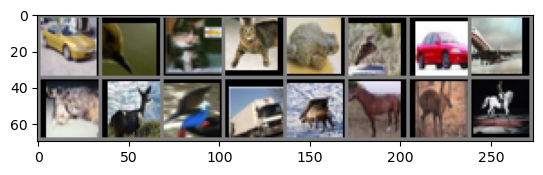

car   bird  cat   cat   frog  bird  car   plane cat   deer  bird  truck deer  horse deer  horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network

In [4]:
# Copy the neural network from the Neural Networks section before and 
# modify it to take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        ##Normalise la martice convolution -> Parameter nb couche conv
        self.batchNorm1 = nn.BatchNorm2d(13)
        self.batchNorm2 = nn.BatchNorm2d(23)
        self.batchNorm3 = nn.BatchNorm2d(33)
        self.batchNorm4 = nn.BatchNorm2d(43)
        self.batchNorm5 = nn.BatchNorm2d(53)
        self.batchNorm6 = nn.BatchNorm2d(63)
        self.batchNorm7 = nn.BatchNorm2d(73)
        self.batchNorm8 = nn.BatchNorm2d(83)
        self.batchNorm9 = nn.BatchNorm2d(93)
        
        #Dropout
        self.dropout = nn.Dropout(0.2)
        
        #Pools
        self.pool = nn.MaxPool2d(2, 2)
        
        #Augmenter rapidement le nombre de output au début
        ##padding =1 -> Sans rognange on rste à 32 tailles de couches
        self.conv1 = nn.Conv2d( 3, 13, 3, padding=1) #entrée 32 tailles de couche -> 30 (32 - (3-1))
        self.conv2 = nn.Conv2d(13, 23, 3, padding=1) 
        self.conv3 = nn.Conv2d(23, 33, 3, padding=1) 
        self.conv4 = nn.Conv2d(33, 43, 3, padding=1) 
        self.conv5 = nn.Conv2d(43, 53, 3, padding=1) 
        self.conv6 = nn.Conv2d(53, 63, 3, padding=1) 
        self.conv7 = nn.Conv2d(63, 73, 3, padding=1)
        self.conv8 = nn.Conv2d(73, 83, 3, padding=1)
        self.conv9 = nn.Conv2d(83, 93, 3, padding=1)
        
        #Fcts
        self.fc1 = nn.Linear(93 * 4 * 4, 10) #completement connectée
    
    def forward(self, x):

        x = F.relu(self.batchNorm1(self.conv1(x))) #32
        x = F.relu(self.batchNorm2(self.conv2(x))) #32
        x = F.relu(self.batchNorm3(self.conv3(x))) #32
        x = self.pool(x) # -> 16
        
        x = F.relu(self.batchNorm4(self.conv4(x))) #16
        x = F.relu(self.batchNorm5(self.conv5(x))) #16
        x = F.relu(self.batchNorm6(self.conv6(x))) #16
        x = self.pool(x) # -> 8
        
        x = F.relu(self.batchNorm7(self.conv7(x))) #8
        x = F.relu(self.batchNorm8(self.conv8(x))) #8
        x = F.relu(self.batchNorm9(self.conv9(x))) #8
        x = self.pool(x) # -> 4
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(self.dropout(x))
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net()
net.to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Dans la partie entraînement du réseau CNN, lister les différentes couches et sous-couches.
Donner la taille des différents tenseurs de données Xn et de poids Wn le long du calcul.
Modifier le programme pour faire l'évaluation après chaque époque et aussi avant la première (faire une fonction spécialisée). Supprimer les autres affichages intermédiaires.
Modifier les fonctions pour calculer à chaque étape le nombre d'opérations flottantes effectuées, séparément pour les additions, les multiplications, les maximums et le total.
Afficher en fin de passe, en plus du taux d'erreur global, le nombre d'opérations effectuées, le temps d'exécution, et le nombre d'opérations par seconde.

# Définition du réseau
 - INITIAL
     - X0 = 3072 = 3 x 32 x 32 (3 layers of 32x32)

| Fn | Name              | Args                      | out layers (nb, size) | Wn   | Xn |
|:--:| ----------------: | :-----------------------  | -------------------:  | --:  | --: |
| F1 | Convolution2d     |   (3, 13, 3, padding=1)   | (13, 32x32)            | 351  | 13312 |
| F2 | Batch Norm2d      |   (13)                    | (13, 32x32)            | 351  | 13312 |
| F3 | Relu              |                           | (13, 32x32)            | 6    | 13312 |
| F4 | Convolution2d     |   (13, 23, 3, padding=1)  | (23, 32x32)           | 2691 | 23552 |
| F5 | Batch Norm2d      |   (23)                    | (23, 32x32)           | 2691 | 23552 |
| F6 | Relu              |                           | (23, 32x32)           | 12   | 23552 |
| F7 | Convolution2d     |   (23, 33, 3, padding=1)  | (33, 32x32)           | 6831 | 33792 |
| F8 | Batch Norm2d      |   (33)                    | (33, 32x32)           | 6831 | 33792 |
| F9 | Relu              |                           | (33, 32x32)           | 24   | 33792 |
| F10 | Pooling          |                           | (33, 16x16)           | 0    | 8448 |
|----|-------------------|---------------------------|-----------------------|------|------|
| F11 | Convolution2d     |   (33, 43, 3, padding=1)  | (43, 16x16)          | 12771  | 11008 |
| F12 | Batch Norm2d      |   (13)                    | (43, 16x16)          | 12771  | 11008 |
| F13 | Relu              |                           | (43, 16x16)          | 48    | 11008 |
| F14 | Convolution2d     |   (43, 53, 3, padding=1)  | (53, 16x16)          | 20511 | 13568 |
| F15 | Batch Norm2d      |   (23)                    | (53, 16x16)          | 20511 | 13568 |
| F16 | Relu              |                           | (53, 16x16)          | 96   | 13568 |
| F17 | Convolution2d     |   (53, 63, 3, padding=1)  | (63, 16x16)         | 30051 | 16128 |
| F18 | Batch Norm2d      |   (33)                    | (63, 16x16)         | 30051 | 16128 |
| F19 | Relu              |                           | (63, 16x16)         | 192   | 16128 |
| F20 | Pooling           |                           | (63, 8x8)           | 0     | 4032 |
|-----|-------------------|---------------------------|----------------------|------|------|
| F21 | Convolution2d     |   (63, 73, 3, padding=1)  | (73, 8x8)           | 41391  | 4672 |
| F22 | Batch Norm2d      |   (13)                    | (73, 8x8)           | 41391  | 4672 |
| F23 | Relu              |                           | (73, 8x8)           | 384    | 4672 |
| F24 | Convolution2d     |   (73, 83, 3, padding=1)  | (83, 8x8)           | 54531 | 5312 |
| F25 | Batch Norm2d      |   (23)                    | (83, 8x8)           | 54531 | 5312 |
| F26 | Relu              |                           | (83, 8x8)           | 768   | 5312 |
| F27 | Convolution2d     |   (83, 93, 3, padding=1)  | (93, 8x8)          | 69471 | 5952 |
| F28 | Batch Norm2d      |   (33)                    | (93, 8x8)          | 69471 | 5952 |
| F29 | Relu              |                           | (93, 8x8)          | 192   | 5952 |
| F30 | Pooling           |                           | (93, 4x4)          | 0     | 1488 |
| F31 | Linear            |    (93 * 4 * 4, 10)       | (10, 1x1)          | 10     | 930 |


In [6]:
from torchsummary import summary

#Network Summary
summary(net, (3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 13, 32, 32]          364
├─BatchNorm2d: 1-2                       [-1, 13, 32, 32]          26
├─Conv2d: 1-3                            [-1, 23, 32, 32]          2,714
├─BatchNorm2d: 1-4                       [-1, 23, 32, 32]          46
├─Conv2d: 1-5                            [-1, 33, 32, 32]          6,864
├─BatchNorm2d: 1-6                       [-1, 33, 32, 32]          66
├─MaxPool2d: 1-7                         [-1, 33, 16, 16]          --
├─Conv2d: 1-8                            [-1, 43, 16, 16]          12,814
├─BatchNorm2d: 1-9                       [-1, 43, 16, 16]          86
├─Conv2d: 1-10                           [-1, 53, 16, 16]          20,564
├─BatchNorm2d: 1-11                      [-1, 53, 16, 16]          106
├─Conv2d: 1-12                           [-1, 63, 16, 16]          30,114
├─BatchNorm2d: 1-13                      [-1, 63, 16, 16]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 13, 32, 32]          364
├─BatchNorm2d: 1-2                       [-1, 13, 32, 32]          26
├─Conv2d: 1-3                            [-1, 23, 32, 32]          2,714
├─BatchNorm2d: 1-4                       [-1, 23, 32, 32]          46
├─Conv2d: 1-5                            [-1, 33, 32, 32]          6,864
├─BatchNorm2d: 1-6                       [-1, 33, 32, 32]          66
├─MaxPool2d: 1-7                         [-1, 33, 16, 16]          --
├─Conv2d: 1-8                            [-1, 43, 16, 16]          12,814
├─BatchNorm2d: 1-9                       [-1, 43, 16, 16]          86
├─Conv2d: 1-10                           [-1, 53, 16, 16]          20,564
├─BatchNorm2d: 1-11                      [-1, 53, 16, 16]          106
├─Conv2d: 1-12                           [-1, 63, 16, 16]          30,114
├─BatchNorm2d: 1-13                      [-1, 63, 16, 16]        

### 3. Define the eval methods

In [7]:
#Accuracy of the network
def getNetworkAccuracy(net):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

In [6]:
def getClassAccuracy(net):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    net.eval()

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            #images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

### 4. Train the network
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network

In [7]:
PATH = './cifar_net.pth'

In [8]:
import time

trainingStartTime = time.time()
print('------ EPOCH 0 ---(Avg loss: NA)---------')
getNetworkAccuracy(net)
getClassAccuracy(net)
print(f'Avg loss: NA')

rangeEpochs = range(110)
for epoch in rangeEpochs:  # loop over the dataset multiple times
    #Increase epochs -> Nombre d'itération parmis toutes les images
    basetime = time.time()
    losses = 0.0
    running_loss = 0.0
    net.train()
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #losses += running_loss / 2000
            #running_loss = 0.0
            # print(f'Avg loss: {losses/6:.3f}')
        #losses = 0
    
    net.eval()
    print(f'------ EPOCH {epoch+1} : ({(time.time() - basetime):.2f}s)---(Avg loss:{running_loss/i:.3f})--------')
    getNetworkAccuracy(net)
    
    if epoch == rangeEpochs[-1]:
        getClassAccuracy(net)

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
print(f'Finished Training : ({(time.time() - trainingStartTime):.2f}s)')

------ EPOCH 0 ---(Avg loss: NA)---------
Accuracy of the network on the 10000 test images: 9.81 %
Accuracy for class: plane is 0.1 %
Accuracy for class: car   is 0.4 %
Accuracy for class: bird  is 3.5 %
Accuracy for class: cat   is 3.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 92.8 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.3 %
Avg loss: NA
------ EPOCH 1 : (26.71s)---(Avg loss:1.519)--------
Accuracy of the network on the 10000 test images: 57.89 %
------ EPOCH 2 : (26.69s)---(Avg loss:1.041)--------
Accuracy of the network on the 10000 test images: 67.8 %
------ EPOCH 3 : (26.74s)---(Avg loss:0.855)--------
Accuracy of the network on the 10000 test images: 72.86 %
------ EPOCH 4 : (27.18s)---(Avg loss:0.755)--------
Accuracy of the network on the 10000 test images: 76.15 %
------ EPOCH 5 : (27.72s)---(Avg loss:0.687)--------
Accuracy of the network on the 10000 test

### 5. Eval the network

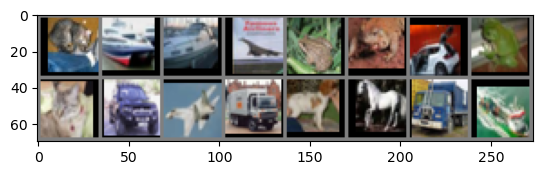

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [30]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

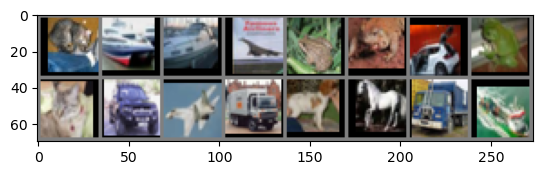

Predicted:  cat   car   ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck plane


In [32]:
#Loading previous results
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

#Prédictions
imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))